
## Portfolio Optimization with Black-Litterman
## Multi-Benchmark Tracking Error Visualization



## Import Required Libraries

In [56]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis


## Download Historical Data


In [ ]:

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA",]
data = yf.download(tickers, start="2015-01-01", end="2025-01-01")["Close"]

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed


In [58]:
data.head()

Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA
Date,,,,,,
2020-01-02,72.538498,94.900497,67.965233,208.635391,152.791107,5.971410
2020-01-03,71.833313,93.748497,67.609688,207.531479,150.888596,5.875833
2020-01-06,72.405670,95.143997,69.411766,211.440018,151.278641,5.900473
2020-01-07,72.065147,95.343002,69.277687,211.897522,149.899307,5.971908
2020-01-08,73.224403,94.598503,69.770775,214.045731,152.286957,5.983109


# Compute log returns

In [59]:
returns = np.log(data / data.shift(1)).dropna()
mu = returns.mean().values * 252   # annualized mean returns
Sigma = returns.cov().values * 252 # annualized covariance

n_assets = len(tickers)

## Define Benchmarks

In [60]:
# Market-cap benchmark (using yfinance market cap at end date)
info = {t: yf.Ticker(t).info for t in tickers}
market_caps = np.array([info[t]["marketCap"] for t in tickers], dtype=float)
market_w = market_caps / market_caps.sum()

bench_eq = np.repeat(1.0 / n_assets, n_assets)
bench_tilt = np.roll(market_w, 2)

benchmarks = {
    "MarketCap": market_w,
    "EqualWeight": bench_eq,
    "Tilted": bench_tilt
}


## Black–Litterman Model


In [61]:
delta = 2.5
pi = delta * Sigma.dot(market_w)  # equilibrium implied returns

# One simple view: AAPL expected to outperform MSFT by 2%
P = np.zeros((1, n_assets))
P[0, tickers.index("AAPL")] = 1
P[0, tickers.index("MSFT")] = -1
q = np.array([0.02])

tau = 0.05
Omega = np.array([[P.dot(tau * Sigma).dot(P.T)[0,0]]])

inv_tauSigma = np.linalg.inv(tau * Sigma)
inv_Omega = np.linalg.inv(Omega)
middle = np.linalg.inv(inv_tauSigma + P.T.dot(inv_Omega).dot(P))
right = inv_tauSigma.dot(pi) + P.T.dot(inv_Omega).dot(q)
mu_bl = middle.dot(right).flatten()

## Efficient Frontier Function

In [62]:
def min_variance_target(mu, Sigma, target_return):
    n = len(mu)
    def obj(x): return 0.5 * x.dot(Sigma).dot(x)
    cons = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: x.dot(mu) - target_return}
    )
    x0 = np.repeat(1.0/n, n)
    res = minimize(obj, x0, constraints=cons, method='SLSQP')
    if not res.success: return None, None, None
    w = res.x
    var = w.dot(Sigma).dot(w)
    ret = w.dot(mu)
    return w, var, ret

def build_frontier(mu, Sigma, label):
    targets = np.linspace(mu.min(), mu.max(), 50)
    weights, vars_, rets = [], [], []
    for t in targets:
        w, v, r = min_variance_target(mu, Sigma, t)
        if w is not None:
            weights.append(w); vars_.append(v); rets.append(r)
    return {"weights": np.array(weights), "vars": np.array(vars_), "rets": np.array(rets)}

frontiers = {
    "Prior (Implied)": build_frontier(pi, Sigma, "Prior"),
    "Black-Litterman": build_frontier(mu_bl, Sigma, "BL")
}


## Tracking Error Function

In [63]:
def tracking_error(w, wb, Sigma):
    diff = w - wb
    return np.sqrt(diff.dot(Sigma).dot(diff))

te_results = {}
for label, data in frontiers.items():
    rets, ws = data["rets"], data["weights"]
    te_matrix = np.zeros((len(ws), len(benchmarks)))
    for i, w in enumerate(ws):
        for j, (bn_name, wb) in enumerate(benchmarks.items()):
            te_matrix[i,j] = tracking_error(w, wb, Sigma)
    te_results[label] = {"rets": rets, "te": te_matrix}

## Plots

### Efficient Frontier

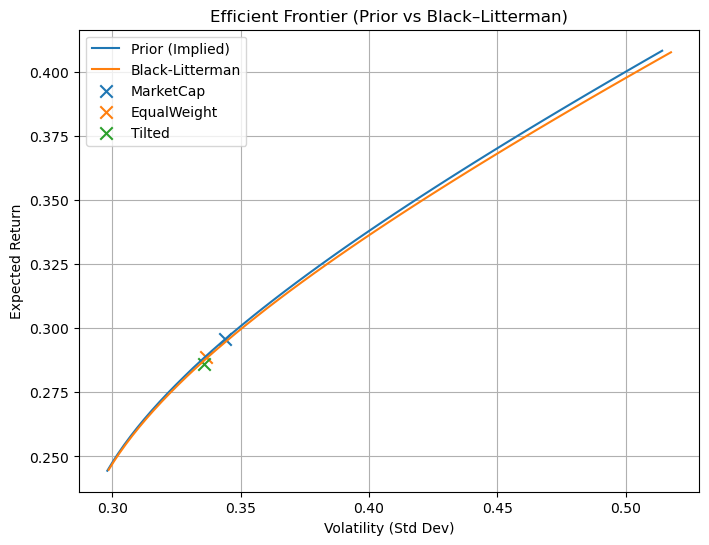

In [64]:
plt.figure(figsize=(8,6))
for label, data in frontiers.items():
    sds = np.sqrt(data["vars"])
    plt.plot(sds, data["rets"], label=label)
for name, wb in benchmarks.items():
    ret_b = wb.dot(pi)
    sd_b = np.sqrt(wb.dot(Sigma).dot(wb))
    plt.scatter(sd_b, ret_b, label=name, marker="x", s=80)
plt.xlabel("Volatility (Std Dev)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier (Prior vs Black–Litterman)")
plt.legend()
plt.grid(True)
plt.show()

### Tracking Error vs Return (for BL)

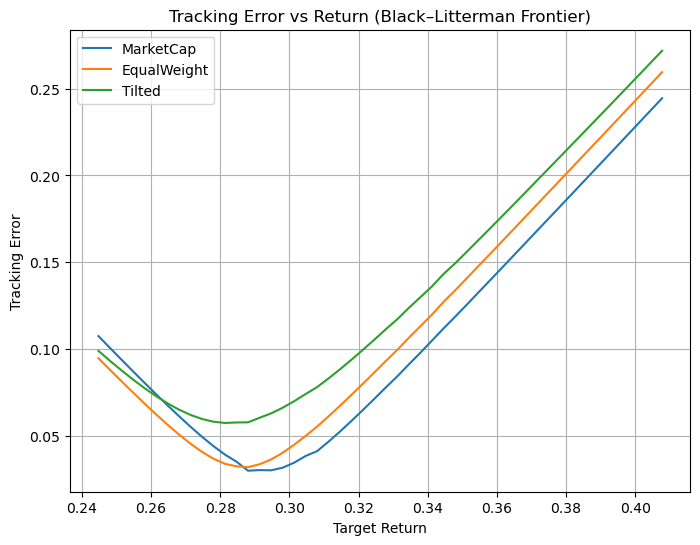

In [65]:
plt.figure(figsize=(8,6))
rets = te_results["Black-Litterman"]["rets"]
te_matrix = te_results["Black-Litterman"]["te"]
for j, (bn_name, _) in enumerate(benchmarks.items()):
    plt.plot(rets, te_matrix[:,j], label=bn_name)
plt.xlabel("Target Return")
plt.ylabel("Tracking Error")
plt.title("Tracking Error vs Return (Black–Litterman Frontier)")
plt.legend()
plt.grid(True)
plt.show()

## Example Portfolio Summary

In [66]:
rets = frontiers["Black-Litterman"]["rets"]
sds = np.sqrt(frontiers["Black-Litterman"]["vars"])
idx = np.argmax(rets/sds)  # max Sharpe approx
w_star = frontiers["Black-Litterman"]["weights"][idx]

print("Selected Portfolio (Black–Litterman Max Sharpe Approx)")
print("Target Return:", rets[idx])
print("Volatility:", sds[idx])
print("Weights:", dict(zip(tickers, np.round(w_star,4))))

print("\nTracking Errors vs Benchmarks:")
for name, wb in benchmarks.items():
    print(f"{name}: {tracking_error(w_star, wb, Sigma):.4f}")

Selected Portfolio (Black–Litterman Max Sharpe Approx)
Target Return: 0.29467847068632325
Volatility: 0.3440854106283292
Weights: {'AAPL': np.float64(0.2697), 'MSFT': np.float64(0.0953), 'GOOGL': np.float64(0.1476), 'AMZN': np.float64(0.1352), 'META': np.float64(0.1235), 'NVDA': np.float64(0.2286)}

Tracking Errors vs Benchmarks:
MarketCap: 0.0303
EqualWeight: 0.0365
Tilted: 0.0630


## Optimizers

## Risk-free rate (annualized)

In [67]:
rf = 0.02

## Mean-Variance Optimizer (maximize return - lambda*variance)

In [68]:
def mean_variance_opt(mu, Sigma, lam=0.5):
    n = len(mu)
    def obj(w): 
        return -(w.dot(mu) - lam * w.dot(Sigma).dot(w))  # negative for minimization
    cons = ({'type':'eq', 'fun': lambda w: np.sum(w)-1})
    w0 = np.repeat(1/n, n)
    res = minimize(obj, w0, constraints=cons)
    return res.x

## Max Sharpe Ratio Optimizer

In [69]:
def max_sharpe_opt(mu, Sigma, rf=0.0):
    n = len(mu)
    def obj(w):
        ret = w.dot(mu)
        vol = np.sqrt(w.dot(Sigma).dot(w))
        return -(ret - rf)/vol
    cons = ({'type':'eq', 'fun': lambda w: np.sum(w)-1})
    w0 = np.repeat(1/n, n)
    res = minimize(obj, w0, constraints=cons)
    return res.x

## Higher Moments Optimizer (Skew-Kurt adjusted utility)

In [70]:
def higher_moments_opt(returns, lam=0.5, eta=0.1, kappa=0.05):
    n = returns.shape[1]
    def obj(w):
        port_ret = returns.dot(w)
        mu_p = port_ret.mean()*252
        var_p = port_ret.var()*252
        skew_p = skew(port_ret)
        kurt_p = kurtosis(port_ret)
        U = mu_p - lam*var_p + eta*skew_p - kappa*kurt_p
        return -U
    cons = ({'type':'eq', 'fun': lambda w: np.sum(w)-1})
    w0 = np.repeat(1/n, n)
    res = minimize(obj, w0, constraints=cons)
    return res.x

## Run Optimizers on Black-Litterman Posterior

In [71]:
w_mv = mean_variance_opt(mu_bl, Sigma, lam=0.5)
w_sharpe = max_sharpe_opt(mu_bl, Sigma, rf=rf)
w_hm = higher_moments_opt(returns, lam=0.5, eta=0.1, kappa=0.05)


optimizers = {
    "Mean-Variance": w_mv,
    "Max Sharpe": w_sharpe,
    "Higher Moments": w_hm
}

print("\n=== Optimized Portfolios (Black-Litterman) ===")
for name, w in optimizers.items():
    ret = w.dot(mu_bl)
    vol = np.sqrt(w.dot(Sigma).dot(w))
    print(f"\n{name} Optimizer")
    print("Return:", round(ret,4), "Vol:", round(vol,4))
    print("Weights:", dict(zip(tickers, np.round(w,4))))
    for bn, wb in benchmarks.items():
        te = tracking_error(w, wb, Sigma)
        print(f"TE vs {bn}: {te:.4f}")


=== Optimized Portfolios (Black-Litterman) ===

Mean-Variance Optimizer
Return: 0.426 Vol: 0.5504
Weights: {'AAPL': np.float64(0.1491), 'MSFT': np.float64(-0.0282), 'GOOGL': np.float64(-0.1244), 'AMZN': np.float64(0.424), 'META': np.float64(-0.3419), 'NVDA': np.float64(0.9214)}
TE vs MarketCap: 0.2831
TE vs EqualWeight: 0.2980
TE vs Tilted: 0.3099

Max Sharpe Optimizer
Return: 0.303 Vol: 0.3542
Weights: {'AAPL': np.float64(0.2695), 'MSFT': np.float64(0.1006), 'GOOGL': np.float64(0.1374), 'AMZN': np.float64(0.149), 'META': np.float64(0.0698), 'NVDA': np.float64(0.2737)}
TE vs MarketCap: 0.0343
TE vs EqualWeight: 0.0474
TE vs Tilted: 0.0715

Higher Moments Optimizer
Return: 0.5389 Vol: 1.0051
Weights: {'AAPL': np.float64(2.0287), 'MSFT': np.float64(-0.4817), 'GOOGL': np.float64(-0.6167), 'AMZN': np.float64(-0.7516), 'META': np.float64(-1.26), 'NVDA': np.float64(2.0813)}
TE vs MarketCap: 0.8463
TE vs EqualWeight: 0.8674
TE vs Tilted: 0.8909


## Plot Optimized Portfolios on Efficient Frontier

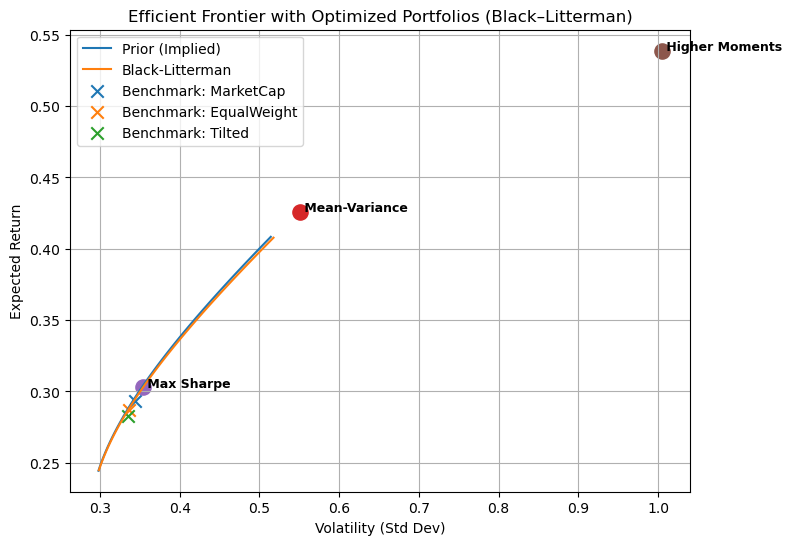

In [72]:
plt.figure(figsize=(8,6))

# Plot prior and BL frontiers
for label, data in frontiers.items():
    sds = np.sqrt(data["vars"])
    plt.plot(sds, data["rets"], label=label)

# Plot benchmarks
for name, wb in benchmarks.items():
    ret_b = wb.dot(mu_bl)
    sd_b = np.sqrt(wb.dot(Sigma).dot(wb))
    plt.scatter(sd_b, ret_b, marker="x", s=80, label=f"Benchmark: {name}")

# Plot optimized portfolios
for name, w in optimizers.items():
    ret = w.dot(mu_bl)
    vol = np.sqrt(w.dot(Sigma).dot(w))
    plt.scatter(vol, ret, s=120, marker="o")
    plt.text(vol, ret, f" {name}", fontsize=9, weight="bold")

plt.xlabel("Volatility (Std Dev)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier with Optimized Portfolios (Black–Litterman)")
plt.legend()
plt.grid(True)
plt.show()

In [73]:
## Plot Optimized Portfolios on Tracking Error Curves

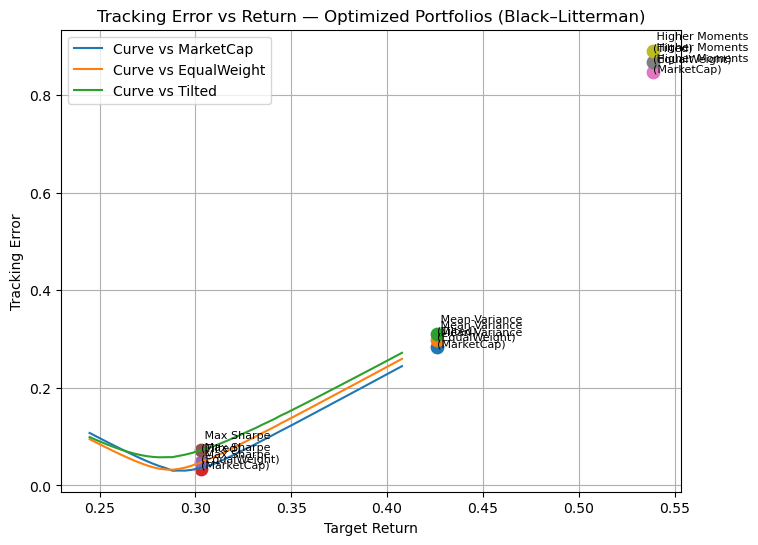

In [74]:
plt.figure(figsize=(8,6))

rets = te_results["Black-Litterman"]["rets"]
te_matrix = te_results["Black-Litterman"]["te"]

# Plot TE curves
for j, (bn_name, _) in enumerate(benchmarks.items()):
    plt.plot(rets, te_matrix[:,j], label=f"Curve vs {bn_name}")

# Plot optimizers' TE vs return
for name, w in optimizers.items():
    ret = w.dot(mu_bl)
    for bn_name, wb in benchmarks.items():
        te = tracking_error(w, wb, Sigma)
        plt.scatter(ret, te, marker="o", s=80)
        plt.text(ret, te, f" {name}\n({bn_name})", fontsize=8)

plt.xlabel("Target Return")
plt.ylabel("Tracking Error")
plt.title("Tracking Error vs Return — Optimized Portfolios (Black–Litterman)")
plt.legend()
plt.grid(True)
plt.show()